In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3641 (delta 4), reused 6 (delta 2), pack-reused 3629
Receiving objects: 100% (3641/3641), 632.97 MiB | 30.11 MiB/s, done.
Resolving deltas: 100% (1446/1446), done.
Checking out files: 100% (1174/1174), done.


In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              224KB  2021-04-24 17:07:26           3642  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2115  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            442  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1355  
mathurinache/twitter-edge-nodes           

In [ ]:
! unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0442-

In [ ]:
df  = pd.read_csv('/content/covid-chestxray-dataset/metadata.csv')
dfCovid = df[df['finding']=='Pneumonia/Viral/COVID-19']
dfCovid = dfCovid[(dfCovid.view == "AP") | (dfCovid.view == 'PA')]
print(len(df),len(dfCovid))
df.head(2)

950 342


,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


In [ ]:
dfCovid.view.value_counts()

PA    196
AP    146
Name: view, dtype: int64

In [ ]:
images = dfCovid['filename'].values.tolist()

In [ ]:
image_path  = '/content/covid-chestxray-dataset/images'

In [ ]:
os.makedirs('/content/covid19-data/train/covid19')
os.makedirs('/content/covid19-data/train/normal')
covidpath = '/content/covid19-data/train/covid19'
normalpath = '/content/covid19-data/train/normal'

for image in images:
  shutil.copy(os.path.join(image_path,image),os.path.join(covidpath,image))

In [ ]:
for image in os.listdir('/content/chest_xray/train/NORMAL')[:300]:
    shutil.copy(os.path.join('/content/chest_xray/train/NORMAL', image), os.path.join(normalpath, image))

In [ ]:
data_path = '/content/covid19-data/train'

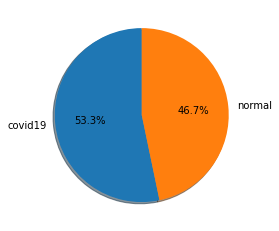

In [ ]:
class_names = os.listdir(data_path)
image_count = {}
for i in class_names:
  image_count[i] = len(os.listdir(os.path.join(data_path,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()


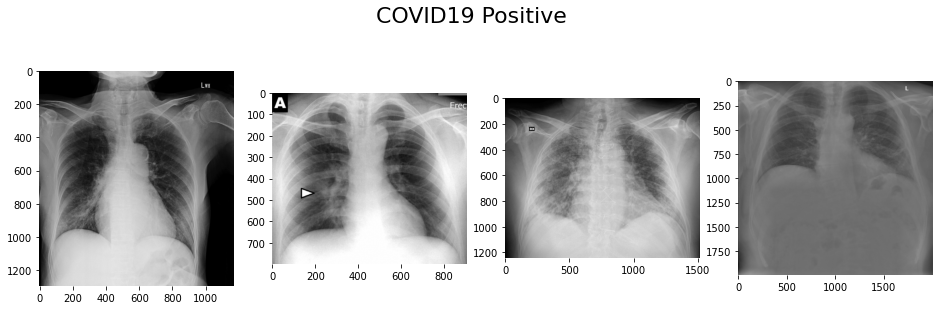

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(covidpath)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(covidpath, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

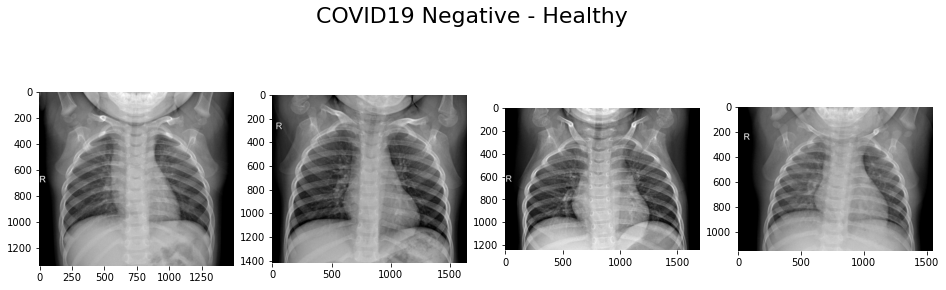

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(normalpath)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(normalpath, image))
    
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {'train' : 
                             transforms.Compose([
                                   transforms.Resize((150,150)),
                                   transforms.RandomRotation(10),
                                   transforms.RandomHorizontalFlip(0.4),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=mean_nums,std = std_nums)]) , 
              
                 'val' :     transforms.Compose([
                                         transforms.Resize((150,150)),
                                         transforms.CenterCrop(150),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=mean_nums,std = std_nums)])
                      }

In [ ]:
def load_split_train_test(dir,val_size=0.2):
  train_data = datasets.ImageFolder(dir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
  test_data = datasets.ImageFolder(dir,
                    transform=data_transforms['val'])
  num_train = len(train_data)
  indices = list(range(num_train))
  split = int(np.floor(val_size*num_train))
  np.random.shuffle(indices)
  train_idx, test_idx = indices[split:], indices[:split]
  dataset_size = {"train":len(train_idx), "val":len(test_idx)}
  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler  = SubsetRandomSampler(test_idx)
  trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
  testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
  return trainloader, testloader, dataset_size

trainloader, valloader, dataset_size = load_split_train_test(data_path, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)
    

['covid19', 'normal']


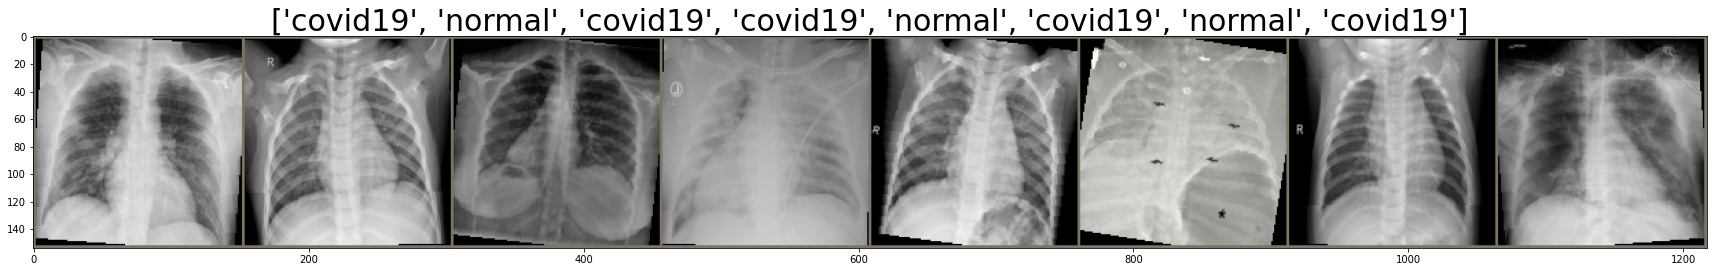

In [ ]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [ ]:
torch.cuda.empty_cache()
model = models.inception_v3(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(in_features=num_ftrs, out_features=len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning


In [ ]:
def CNN_Model(pretrained=True):
    model = models.densenet201(pretrained=pretrained)
    # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(in_features=num_ftrs, out_features=len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning

    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler




Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


In [ ]:
"""model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
print(model.classifier)

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
print(model.classifier) 

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
18096770


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()
            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------


train Loss: 0.2284 | train Accuracy: 0.9027


val Loss: 0.0495 | val Accuracy: 0.9844 | Kappa Score: 0.9688
Val loss Decreased from inf to 0.0495 
Saving Weights... 

Epoch 2/10
----------


train Loss: 0.1378 | train Accuracy: 0.9533


val Loss: 0.0549 | val Accuracy: 0.9844 | Kappa Score: 0.9665

Epoch 3/10
----------


train Loss: 0.1725 | train Accuracy: 0.9339


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0443 | val Accuracy: 0.9922 | Kappa Score: nan
Val loss Decreased from 0.0495 to 0.0443 
Saving Weights... 

Epoch 4/10
----------


train Loss: 0.1514 | train Accuracy: 0.9377


val Loss: 0.0513 | val Accuracy: 0.9844 | Kappa Score: 0.9688

Epoch 5/10
----------


train Loss: 0.1586 | train Accuracy: 0.9455


val Loss: 0.0443 | val Accuracy: 0.9922 | Kappa Score: 0.9844
Val loss Decreased from 0.0443 to 0.0443 
Saving Weights... 

Epoch 6/10
----------


train Loss: 0.1574 | train Accuracy: 0.9494


val Loss: 0.0520 | val Accuracy: 0.9844 | Kappa Score: nan

Epoch 7/10
----------


train Loss: 0.1234 | train Accuracy: 0.9475


val Loss: 0.0464 | val Accuracy: 0.9922 | Kappa Score: 0.9750

Epoch 8/10
----------


train Loss: 0.1514 | train Accuracy: 0.9475


val Loss: 0.0514 | val Accuracy: 0.9844 | Kappa Score: 0.9688

Epoch 9/10
----------


train Loss: 0.2272 | train Accuracy: 0.9300


val Loss: 0.0513 | val Accuracy: 0.9844 | Kappa Score: 0.9665

Epoch 10/10
----------


train Loss: 0.1569 | train Accuracy: 0.9455


val Loss: 0.0495 | val Accuracy: 0.9844 | Kappa Score: 0.9665

Training complete in 8m 36s
Best val loss: 0.0443


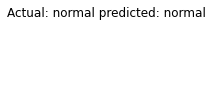

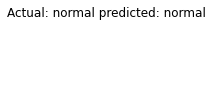

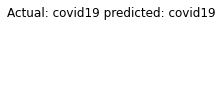

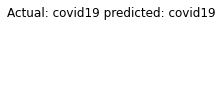

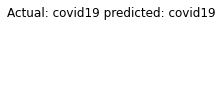

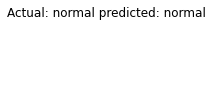

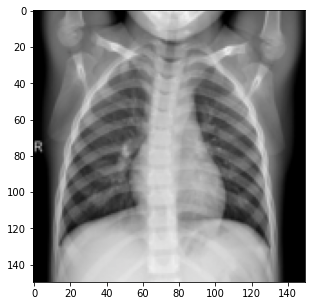

In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
#! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              224KB  2021-04-24 17:07:26           3645  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2116  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            442  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1355  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
!unzip covid19-radiography-database.zip -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: /content/COVID-19_Radiogr

In [ ]:
os.makedirs('/content/covid19-data/test/covid19')
os.makedirs('/content/covid19-data/test/normal')

COVID_TEST = '/content/COVID-19_Radiography_Dataset/COVID'
NORMAL_TEST = '/content/COVID-19_Radiography_Dataset/Normal'

for image in os.listdir(COVID_TEST)[:100]:
    shutil.copy(os.path.join(COVID_TEST, image), os.path.join('/content/covid19-data/test/covid19', image))
for image in os.listdir(NORMAL_TEST)[:100]:
    shutil.copy(os.path.join(NORMAL_TEST, image), os.path.join('/content/covid19-data/test/normal', image))

In [ ]:
TEST_DATA_PATH = '/content/covid19-data/test'

test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [ ]:
y_true_list

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69       100
           1       1.00      0.11      0.20       100

    accuracy                           0.56       200
   macro avg       0.76      0.56      0.45       200
weighted avg       0.76      0.56      0.45       200



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

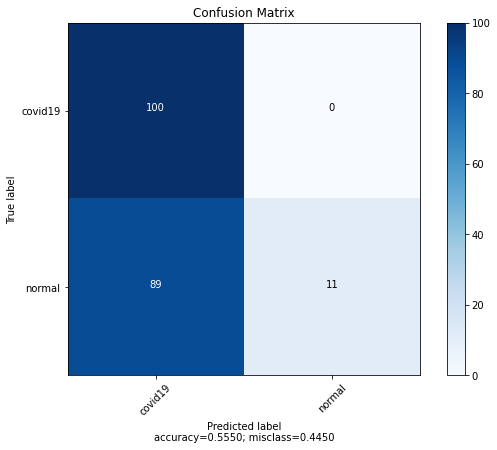

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [ ]:
!ls covid19-data/train

In [ ]:
FileCheckpoints.checkpoint_dir = '_ipynb_checkpoints'

In [ ]:
os.makedirs('/content/sagar/suman/arun')
os.makedirs('/content/sagar/suman/farkale')

In [ ]:
'/content/covid19-data/train'

In [ ]:
c = os.listdir('/content/sagar/suman')

In [ ]:
c = models.MobileNetV2()

TypeError: ignored

512